# **Conditional Generative Adversarial Network on the MNIST fashion dataset**

C-GAN to generate images of footwear with reference to the MNIST Fashion dataset

Necessary file downloads

In [17]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2019-06-21 11:13:40--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.138
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.72.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  17.0MB/s    in 1.5s    

2019-06-21 11:13:42 (17.0 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2019-06-21 11:13:43--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.138
Connecting to fashion-mnist.s3-website.eu-central-1.amaz

In [18]:
!mkdir mnist_fashion
!cp *.gz mnist_fashion/

mkdir: cannot create directory ‘mnist_fashion’: File exists


In [63]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist_fashion/', one_hot = True)

Extracting mnist_fashion/train-images-idx3-ubyte.gz


W0621 13:54:19.184975 140200076445568 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.


Extracting mnist_fashion/train-labels-idx1-ubyte.gz
Extracting mnist_fashion/t10k-images-idx3-ubyte.gz
Extracting mnist_fashion/t10k-labels-idx1-ubyte.gz


**Hyperparameters**

1.   lr : Learning rate set to 0.0002 for the Adam optimizer
2.   epochs : Number of training epochs
3.   batch_size : batch size
3.   image_dim : Dimension of flattened $28*28$ MNIST fashion image
4.   gen_dim : Dimension of Generator hidden layer
5.   dis_dim : Dimension of Discriminator hidden layer
7.   z_dim : Dimension of Generator noise
8.   lab_dim : Number of labels in the MNIST fashion dataset

In [0]:
lr = 2e-4
batch_size = 128
epochs = 100000
image_dim = 784
gen_dim = 256
dis_dim = 256
z_dim = 100
lab_dim = 10

In [66]:
mnist.train.labels.shape

(55000, 10)

Xavier initialization, given by $1/{\sqrt{\frac{n}{2}}}$ where $n$ represents input dimension

In [0]:
def Xavier(in_shape):
  return tf.random_normal(shape = in_shape, stddev = 1./tf.sqrt(in_shape[0]/2.))

Essential weights and biases

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
weights = {
    'dis_h' : tf.Variable(Xavier([image_dim + lab_dim, dis_dim])),
    'dis_final' : tf.Variable(Xavier([dis_dim, 1])),
    'gen_h' : tf.Variable(Xavier([z_dim + lab_dim, gen_dim])),
    'gen_final' : tf.Variable(Xavier([gen_dim, image_dim]))
}
bias = {
    'dis_h' : tf.Variable(Xavier([dis_dim])),
    'dis_final' : tf.Variable(Xavier([1])),
    'gen_h' : tf.Variable(Xavier([gen_dim])),
    'gen_final' : tf.Variable(Xavier([image_dim]))
}

We define the discriminator as a simple hidden layer FC network, with the input as a concatenation of the image and its corresponding label 

In [0]:
def Discriminator(inp,y):
  x = tf.concat(axis = 1, values = [inp,y])
  hidden = tf.nn.relu(tf.add(tf.matmul(x, weights['dis_h']), bias['dis_h']))
  final = tf.add(tf.matmul(hidden, weights['dis_final']), bias['dis_final'])
  out = tf.nn.sigmoid(final)
  return final, out

We define the Generator as a simple hidden layer FC network with the output dimension the same as the image dimension we wish to generate

In [0]:
def Generator(inp, y):
  x = tf.concat(axis = 1, values = [inp,y])
  hidden = tf.nn.relu(tf.add(tf.matmul(x, weights['gen_h']), bias['gen_h']))
  final = tf.add(tf.matmul(hidden, weights['gen_final']), bias['gen_final'])
  out = tf.nn.sigmoid(final)
  return out

Define the noise, input and label placeholders respectively

In [0]:
z_in = tf.placeholder(tf.float32, shape = [None, z_dim], name = 'noise')
x_in = tf.placeholder(tf.float32, shape = [None, image_dim], name = 'input')
y_in = tf.placeholder(tf.float32, shape = [None, lab_dim], name = 'labels')

In [0]:
with tf.name_scope("Generator") as scope:
  out_gen = Generator(z_in, y_in)
with tf.name_scope("Discriminator") as scope:
  real_temp_dis, real_dis = Discriminator(x_in, y_in)
  fake_temp_dis, fake_dis = Discriminator(out_gen, y_in)

The discriminator and the generator loss functions are defined as follows

$L_d = \log{(D(x))} + \log{(1 - D(G(z)))}$ 

$L_g = \log{(D(G(z)))}$

In [0]:
eps = 1e-5
with tf.name_scope("Dis_loss") as scope:
  disloss = -tf.reduce_mean(tf.log(real_dis + eps) + tf.log(1 - fake_dis + eps))
with tf.name_scope("Gen_loss") as scope:
  genloss = -tf.reduce_mean(tf.log(fake_dis + eps))

dis_loss_total = tf.summary.scalar("dis_total_loss", disloss)
gen_loss_total = tf.summary.scalar("gen_total_loss", genloss)

In [0]:
gen_var = [weights['gen_h'], weights['gen_final'], bias['gen_h'], bias['gen_final']]
dis_var = [weights['dis_h'], weights['dis_final'], bias['dis_h'], bias['dis_final']]

Optimize the parameters of the adversarial networks separately

In [0]:
with tf.name_scope("opt_dis") as scope:
  disopt = tf.train.AdamOptimizer(learning_rate = lr).minimize(disloss, var_list = dis_var)
with tf.name_scope("opt_gen") as scope:
  genopt = tf.train.AdamOptimizer(learning_rate = lr).minimize(genloss, var_list = gen_var)

In [0]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
writer = tf.summary.FileWriter('./log', sess.graph)

In [84]:
for epoch in range(epochs):
  x_batch, y_batch = mnist.train.next_batch(batch_size)
  
  z_noise = np.random.uniform(-1., 1., size = [batch_size, z_dim])
  _, dis_loss_epoch = sess.run([disopt, disloss], feed_dict = {x_in : x_batch, z_in : z_noise, y_in : y_batch})
  _, gen_loss_epoch = sess.run([genopt, genloss], feed_dict = {z_in : z_noise, y_in : y_batch})
  dis_summary = sess.run(dis_loss_total, feed_dict = {x_in : x_batch, z_in : z_noise, y_in : y_batch})
  writer.add_summary(dis_summary, epoch)
  gen_summary = sess.run(gen_loss_total, feed_dict = {z_in : z_noise, y_in : y_batch})
  writer.add_summary(gen_summary, epoch)
  
  if epoch%2000 == 0:
    print("Step : {0}, Generator loss : {1}, Discriminator loss : {2}".format(epoch, gen_loss_epoch, dis_loss_epoch))
  

Step : 0, Generator loss : 0.38625970482826233, Discriminator loss : 2.075226306915283
Step : 2000, Generator loss : 6.005610466003418, Discriminator loss : 0.02016809955239296
Step : 4000, Generator loss : 4.00145149230957, Discriminator loss : 0.16196420788764954
Step : 6000, Generator loss : 3.61458683013916, Discriminator loss : 0.2306489646434784
Step : 8000, Generator loss : 4.829440116882324, Discriminator loss : 0.18378674983978271
Step : 10000, Generator loss : 3.080716133117676, Discriminator loss : 0.3623693585395813
Step : 12000, Generator loss : 4.414306640625, Discriminator loss : 0.3189312815666199
Step : 14000, Generator loss : 3.9273455142974854, Discriminator loss : 0.26803240180015564
Step : 16000, Generator loss : 3.8553659915924072, Discriminator loss : 0.42481592297554016
Step : 18000, Generator loss : 2.880239486694336, Discriminator loss : 0.5083613395690918
Step : 20000, Generator loss : 2.859682321548462, Discriminator loss : 0.5615246295928955
Step : 22000, G

Visualise the output with a $6\times6$ canvas displaying generated images with an assigned condition label = $5$ (generates shoes)

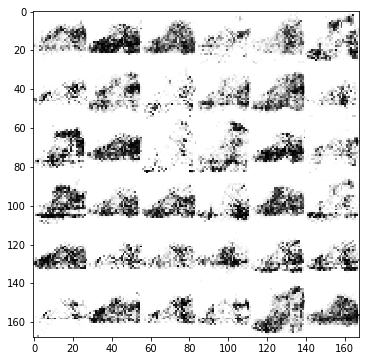

In [93]:
n = 6
canvas = np.empty((28*n, 28*n))
for i in range(n):
  z_noise = np.random.uniform(-1., 1., size = [batch_size, z_dim])
  tmp_labels = np.zeros((batch_size), dtype = int) + 5
  labels = np.eye(10)[tmp_labels]
  g = sess.run(out_gen, feed_dict = {z_in : z_noise, y_in : labels})
  g = -1*(g - 1)
  for j in range(n):
    canvas[i*28:(i + 1)*28, j*28:(j+1)*28] = g[j].reshape(28,28)
  
plt.figure(figsize = (n,n))
plt.imshow(canvas, origin= "upper", cmap = "gray")